In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input shape for both models
input_shape = (224, 224, 3)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Directories for training, validation, and test data
train_dir = '/kaggle/input/garbage-classificationsss/train'
val_dir = '/kaggle/input/garbage-classificationsss/val'
test_dir = '/kaggle/input/garbage-classificationsss/test'

# Initialize ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load base models with ImageNet weights, exclude the fully connected top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base models initially
vgg16_base.trainable = False
mobilenet_base.trainable = False

# Create a combined model
input_layer = Input(shape=(224, 224, 3))
vgg16_features = vgg16_base(input_layer)
mobilenet_features = mobilenet_base(input_layer)

# Global pooling layers
vgg16_features = GlobalAveragePooling2D()(vgg16_features)
mobilenet_features = GlobalAveragePooling2D()(mobilenet_features)

# Concatenate features from both models
combined_features = Concatenate()([vgg16_features, mobilenet_features])

# Add dense layer for classification
x = Dense(256, activation='relu')(combined_features)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=output)

# Compile the combined model
combined_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the combined model initially
history = combined_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50  # Adjust epochs as needed
)

# Fine-tune by unfreezing the last layers of both base models
for layer in vgg16_base.layers[-4:]:  # Unfreeze last few layers of VGG16
    layer.trainable = True
for layer in mobilenet_base.layers[-4:]:  # Unfreeze last few layers of MobileNet
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
combined_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_finetune = combined_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50  # Fewer epochs usually work for fine-tuning
)


Found 2377 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 383 images belonging to 6 classes.
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - accuracy: 0.5774 - loss: 1.1061 - val_accuracy: 0.8077 - val_loss: 0.4961
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.8032 - loss: 0.5315 - val_accuracy: 0.8536 - val_loss: 0.3732
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 366ms/step - accuracy: 0.8663 - loss: 0.3928 - val_accuracy: 0.8995 - val_loss: 0.2859
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.8783 - loss: 0.3363 - val_accuracy: 0.9094 - val_loss: 0.2510
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step - accuracy: 0.8969 - loss: 0.2853 - val_accuracy: 0.9181 - val_loss: 0.2389
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.8962 - loss: 0.2896 - val_accuracy: 0.9429 - val_loss: 0.1729
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 363ms/step - accuracy: 0.9192 - loss: 0.2189 - val_accuracy:

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 972ms/step


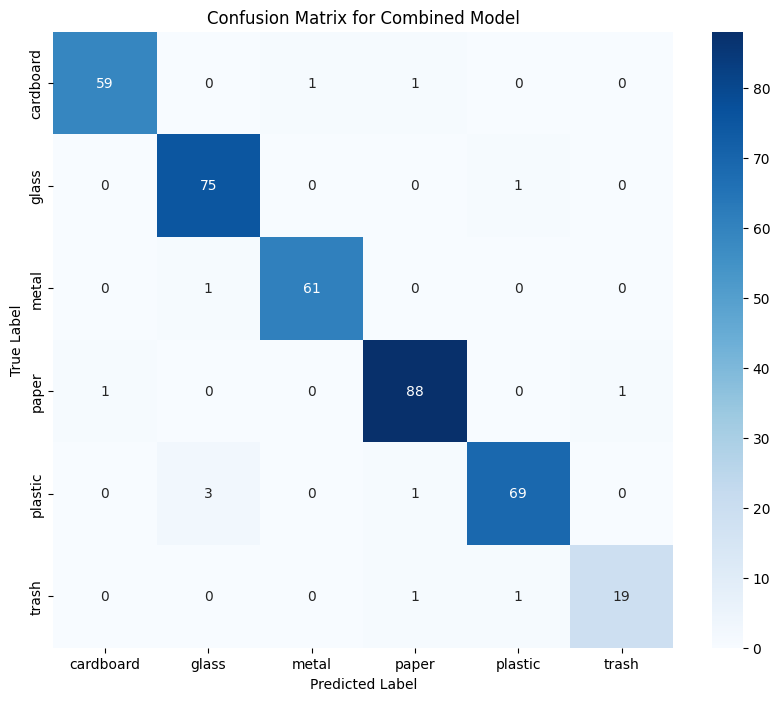

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.98      0.97      0.98        61
       glass       0.95      0.99      0.97        76
       metal       0.98      0.98      0.98        62
       paper       0.97      0.98      0.97        90
     plastic       0.97      0.95      0.96        73
       trash       0.95      0.90      0.93        21

    accuracy                           0.97       383
   macro avg       0.97      0.96      0.96       383
weighted avg       0.97      0.97      0.97       383



In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test data
test_predictions = combined_model.predict(test_generator)
y_pred = np.argmax(test_predictions, axis=1)  # Get the index of the highest probability as predicted class
y_true = test_generator.classes  # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())  # Get class names from the generator

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Combined Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


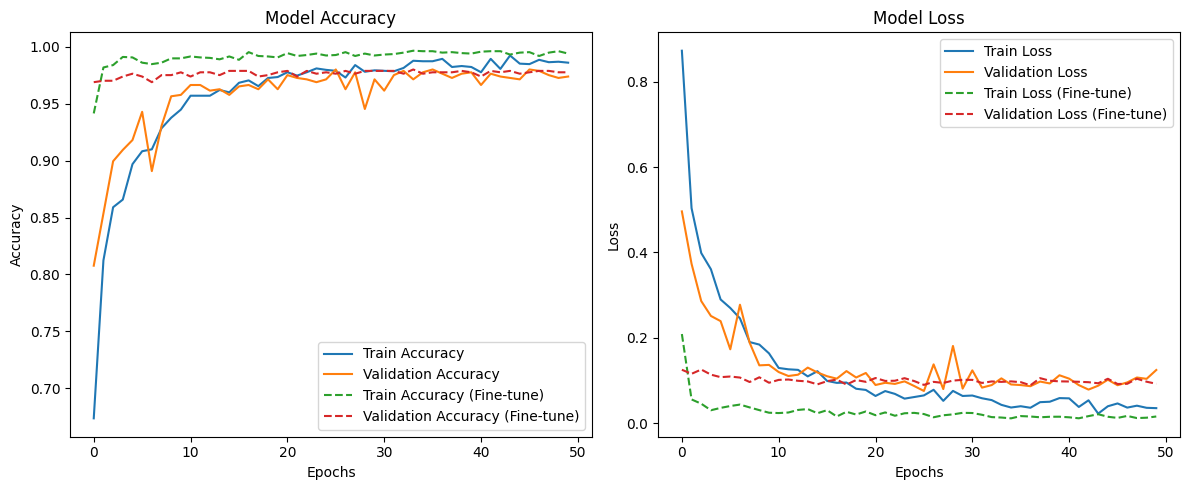

In [4]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy (Fine-tune)', linestyle='--')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tune)', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_finetune.history['loss'], label='Train Loss (Fine-tune)', linestyle='--')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss (Fine-tune)', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [5]:
# Training and validation accuracy after fine-tuning
final_train_accuracy = history_finetune.history['accuracy'][-1] * 100
final_val_accuracy = history_finetune.history['val_accuracy'][-1] * 100

print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

# Testing accuracy
test_loss, test_accuracy = combined_model.evaluate(test_generator, verbose=0)
test_accuracy_percentage = test_accuracy * 100

print(f"Test Accuracy: {test_accuracy_percentage:.2f}%")


Final Training Accuracy: 99.41%
Final Validation Accuracy: 97.77%
Test Accuracy: 96.87%


In [6]:
import os
import numpy as np
from keras.preprocessing import image

# Directory for test data
test_dir = '/kaggle/input/garbage-classificationsss/test'  # Ensure this path exists and contains images

# Class labels (ensure this matches your training order)
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the test generator

# Initialize lists to store predictions and true labels
predictions_list = []
true_labels_list = []

# Loop through each class directory in the test data
for class_label in class_labels:
    class_dir = os.path.join(test_dir, class_label)
    if os.path.exists(class_dir):
        # Loop through each image in the class folder
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                # Make a prediction with the combined model
                predictions = combined_model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Store the predicted label
                predictions_list.append(predicted_class)
                true_labels_list.append(class_labels.index(class_label))

                # Print the predicted label
                predicted_label = class_labels[predicted_class]
                print(f"Image: {img_name}, Predicted Class: {predicted_label}")

# Calculate the overall accuracy on the test set
accuracy = np.sum(np.array(predictions_list) == np.array(true_labels_list)) / len(true_labels_list)
print(f"Overall Test Accuracy: {accuracy:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: cardboard403.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: cardboard132.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: cardboard3.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard92.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard306.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard89.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard320.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: cardboard248.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: cardboard148.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard117.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: cardboard262.jpg, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━